In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

# Define parameters
seed = 67

In [50]:
# Initial data clean
df = pd.read_csv('data/SAHeart.csv')
df['chd'] = pd.Categorical(df['chd'])
df['famhist'] = pd.Categorical(df['famhist'].map({'Absent':0, 'Present':1})) # One-of-K coding

# Filter outliers if we need to??
#df = df[~( (df[''] > 2) | (df[''] > 1) )]

df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [51]:
# What to predict for Regression
X = df.drop(columns=['ldl', 'chd']).values
# Target
y = df['ldl'].values.reshape(-1, 1)

N, M = X.shape

Artificial neural network (ANN)

Fold 1/10
Fold 1/10
  Inner fold 1/10 done
Fold 2/10
  Inner fold 2/10 done
Fold 3/10
  Inner fold 3/10 done
Fold 4/10
  Inner fold 4/10 done
Fold 5/10
  Inner fold 5/10 done
Fold 6/10
  Inner fold 6/10 done
Fold 7/10
  Inner fold 7/10 done
Fold 8/10
  Inner fold 8/10 done
Fold 9/10
  Inner fold 9/10 done
Fold 10/10
  Inner fold 10/10 done
  Selected hidden_dim=2 (inner-CV mean MSE=3.5734)
    [Outer eval] Hidden units: 1, Validation MSE: 2.5799
    [Outer eval] Hidden units: 2, Validation MSE: 2.6702
    [Outer eval] Hidden units: 10, Validation MSE: 2.9351
    [Outer eval] Hidden units: 50, Validation MSE: 3.3468
Fold 2/10
Fold 1/10
  Inner fold 1/10 done
Fold 2/10
  Inner fold 2/10 done
Fold 3/10
  Inner fold 3/10 done
Fold 4/10
  Inner fold 4/10 done
Fold 5/10
  Inner fold 5/10 done
Fold 6/10
  Inner fold 6/10 done
Fold 7/10
  Inner fold 7/10 done
Fold 8/10
  Inner fold 8/10 done
Fold 9/10
  Inner fold 9/10 done
Fold 10/10
  Inner fold 10/10 done
  Selected hidden_dim=2 (inner-CV m

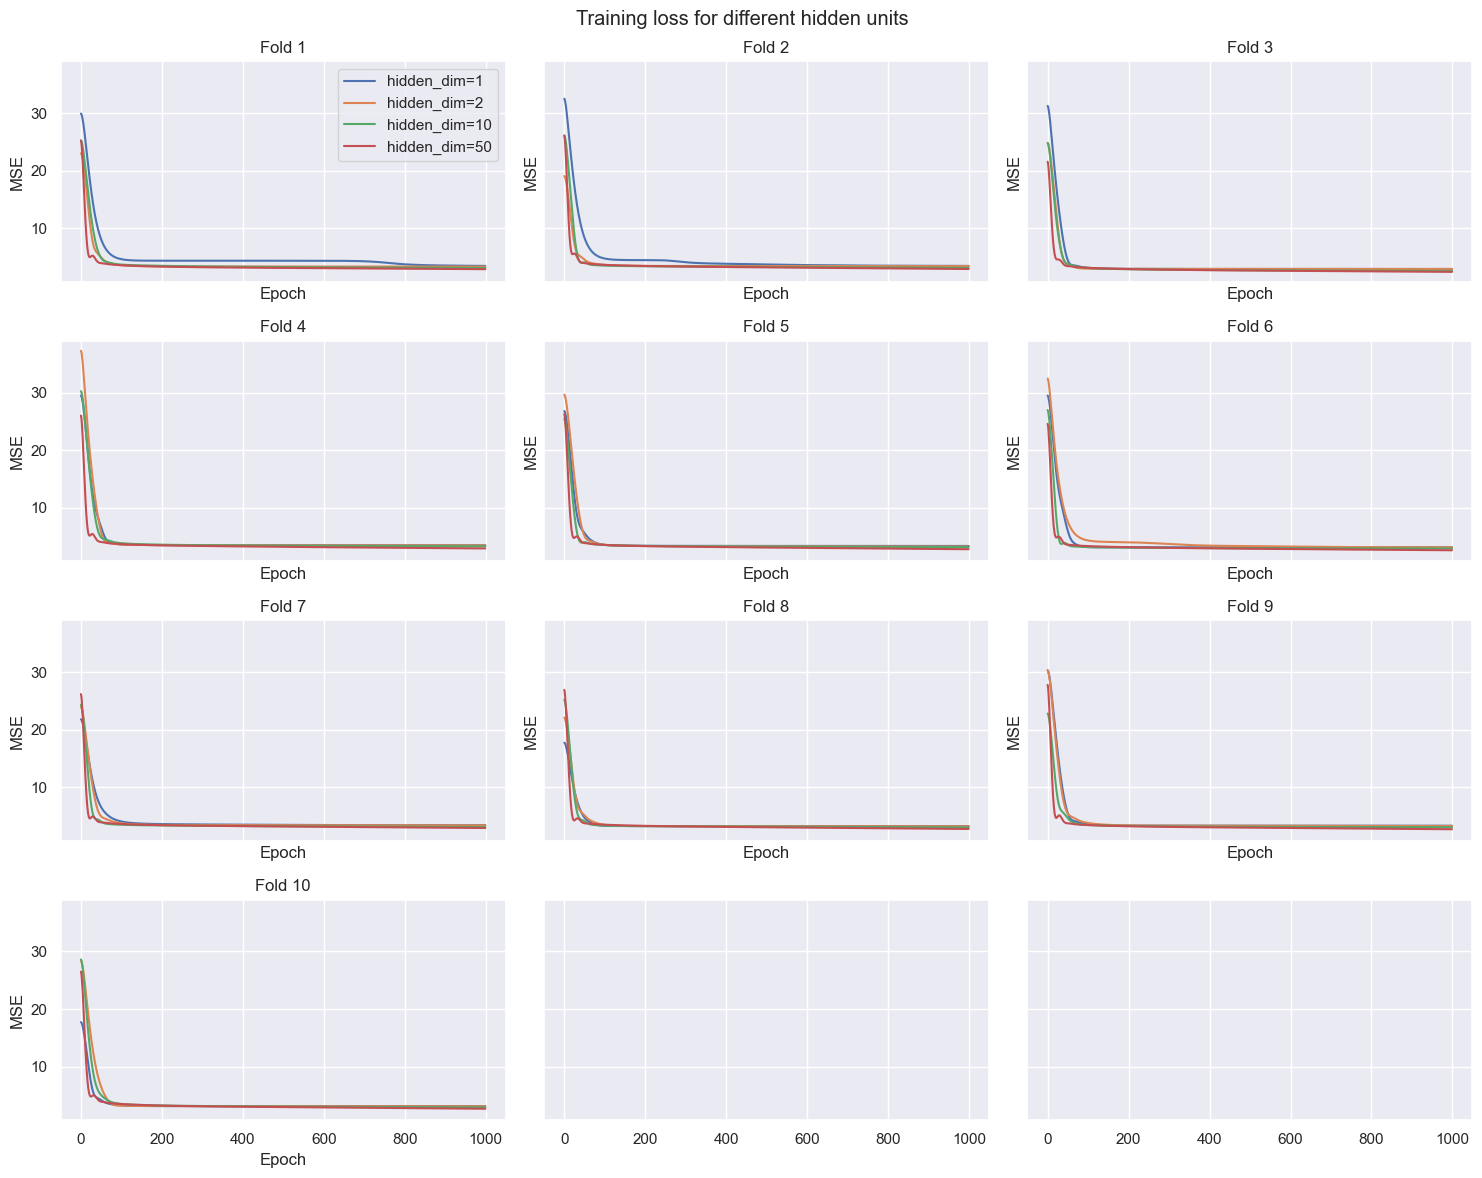

In [52]:
import torch

input_dim = M

hidden_dims = [1, 2, 10, 50]

output_dim = 1

def get_model(input_dim, hidden_dim, output_dim):
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True),     # Input layer
        torch.nn.ReLU(),                                                                # Activation function
        torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True),    # Output layer, no activation function in the end because we want the target to be a value                                                        # Output activation function (for binary classification)
    )

K1 = 10
K2 = 10
CV_outer = KFold(K1, shuffle=True, random_state=seed)

# Define hyperparameters
lr = 0.001
n_epochs = 1000

results = {}
per_fold_best = []

for k1, (train_index_outer, val_index_outer) in enumerate(CV_outer.split(X, y)):
    print(f'Fold {k1+1}/{K1}')
    
    X_train_outer, X_val_outer = X[train_index_outer], X[val_index_outer]
    y_train_outer, y_val_outer = y[train_index_outer], y[val_index_outer]

    CV_inner = KFold(n_splits=K2, shuffle=True, random_state=seed)
    inner_scores = {hd: [] for hd in hidden_dims}

    for k2, (train_index_inner, val_index_inner) in enumerate(CV_inner.split(X_train_outer, y_train_outer)):
        print(f'Fold {k2+1}/{K2}')
        
        X_train_inner = X_train_outer[train_index_inner]        
        X_val_inner   = X_train_outer[val_index_inner]               
        y_train_inner = y_train_outer[train_index_inner]              
        y_val_inner   = y_train_outer[val_index_inner]

        mean, std = X_train_inner.mean(axis=0), X_train_inner.std(axis=0)
        std[std == 0.0] = 1.0  # avoid /0
        X_train = (X_train_inner - mean) / std
        X_val   = (X_val_inner   - mean) / std

        # Convert to torch tensors **from the NORMALIZED arrays**
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train_inner, dtype=torch.float32).view(-1, 1)
        X_val   = torch.tensor(X_val, dtype=torch.float32)
        y_val   = torch.tensor(y_val_inner, dtype=torch.float32).view(-1, 1)

        # Set up a dictionary to store the results for each hyperparameter setting
        results_inner = {hidden_dim: {'train': [], 'val': []} for hidden_dim in hidden_dims}

        for hidden_dim in hidden_dims:
            model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
            criterion = torch.nn.MSELoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

            # train on inner-train
            for epoch in range(n_epochs):
                model.train()
                optimizer.zero_grad()
                loss = criterion(model(X_train), y_train)
                loss.backward()
                optimizer.step()

            # validate on inner-val
            model.eval()
            with torch.no_grad():
                val_mse = criterion(model(X_val), y_val).item()
            inner_scores[hidden_dim].append(val_mse)

        print(f'  Inner fold {k2+1}/{K2} done')

    avg_inner = {hd: float(np.mean(mses)) for hd, mses in inner_scores.items()}
    best_hidden = min(avg_inner, key=avg_inner.get)
    print(f'  Selected hidden_dim={best_hidden} (inner-CV mean MSE={avg_inner[best_hidden]:.4f})')


    # Normalize data here
    mean, std = X_train_outer.mean(axis=0), X_train_outer.std(axis=0)
    X_train_outer = (X_train_outer - mean) / std
    X_val_outer = (X_val_outer - mean) / std

    # Convert to torch tensors
    X_train_outer = torch.tensor(X_train_outer, dtype=torch.float32)
    y_train_outer = torch.tensor(y_train_outer, dtype=torch.float32).view(-1, 1)
    X_val_outer = torch.tensor(X_val_outer, dtype=torch.float32)
    y_val_outer = torch.tensor(y_val_outer, dtype=torch.float32).view(-1, 1)

    results_inner = {hidden_dim: {'train': [], 'val': []} for hidden_dim in hidden_dims}
    best_outer_mse = None

    for hidden_dim in hidden_dims:
        model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
        criteration = torch.nn.MSELoss()  # keep your name
        optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)
        
        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_outer)
            loss = criteration(outputs, y_train_outer)
            loss.backward()
            optimizer.step()

            results_inner[hidden_dim]['train'].append(loss.item())

        # Outer validation
        with torch.no_grad():
            model.eval()
            val_outputs = model(X_val_outer)
            val_loss = criteration(val_outputs, y_val_outer)
            results_inner[hidden_dim]['val'].append(val_loss.item())
            if hidden_dim == best_hidden:
                best_outer_mse = val_loss.item()
            print(f'    [Outer eval] Hidden units: {hidden_dim}, Validation MSE: {val_loss.item():.4f}')

    results[k1] = results_inner
    per_fold_best.append({
        "fold": k1+1,
        "best_hidden_dim": best_hidden,
        "outer_val_mse_of_best": best_outer_mse,
        "inner_mean_mse_per_hd": avg_inner
    })


fig, axs = plt.subplots(4, 3, figsize=(15, 12), sharey=True, sharex=True)
axs = axs.ravel()

for fold in range(K1):
    ax = axs[fold]
    for hidden_dim in hidden_dims:
        ax.plot(results[fold][hidden_dim]['train'], label=f'hidden_dim={hidden_dim}')
    ax.set_title(f'Fold {fold+1}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')

plt.suptitle('Training loss for different hidden units')
plt.tight_layout()
axs[0].legend()
plt.show()

Baseline linear regression model